In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import mmap
import random
import pickle
import argparse
import matplotlib.pyplot as plt
import os

device = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

batch_size = 16
block_size = 64
max_iters = 500
learning_rate = 2e-4
eval_iters = 25
n_embd = 256
n_head = 4
n_layer = 6
dropout = 0.2

print(device)

cuda


In [2]:
with open('openwebtext\\vocab.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text))
# print(chars)
print(len(chars))
vocab_size = len(chars)


31729


In [3]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])


data = torch.tensor(encode(text), dtype=torch.long)
# print(data[:100])

In [4]:
# memory map for using small snippets of text from a single file of any size
def get_random_chunk(split):
    filename = "openwebtext/output_train.txt" if split == 'train' else "openwebtext/output_val.txt"
    with open(filename, 'rb') as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            # Determine the file size and a random position to start reading
            file_size = len(mm)
            start_pos = random.randint(0, (file_size) - block_size*batch_size)

            # Seek to the random position and read the block of text
            mm.seek(start_pos)
            block = mm.read(block_size*batch_size-1)

            # Decode the block to a string, ignoring any invalid byte sequences
            decoded_block = block.decode('utf-8', errors='ignore').replace('\r', '')
            
            # Train and test splits
            data = torch.tensor(encode(decoded_block), dtype=torch.long)
            
    return data


def get_batch(split):
    data = get_random_chunk(split)
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [5]:
#also from bigram 
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [6]:
#also part of transformer (refer video walkthrough) 
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out
    

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x
    

In [7]:
#also from bigram ; modified BigramLanguageModel

class GPTLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        #the number of decoder blocks (1 linear layer for each of them)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        
        
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

model = GPTLanguageModel(vocab_size)


In [8]:
#load prev model 
print('loading model parameters...')
with open('model-01.pkl', 'rb') as f:
    model = pickle.load(f)
print('loaded successfully!')
m = model.to(device)

loading model parameters...
loaded successfully!


In [12]:
train_steps = []
train_losses = []
val_losses = []

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    if iter % eval_iters == 0:
        losses = estimate_loss()

        train_steps.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

        print(
            f"step: {iter}, "
            f"train loss: {losses['train']:.3f}, "
            f"val loss: {losses['val']:.3f}"
        )

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step: 0, train loss: 1.431, val loss: 1.507
step: 25, train loss: 1.786, val loss: 1.644
step: 50, train loss: 1.541, val loss: 1.471
step: 75, train loss: 1.724, val loss: 1.519
step: 100, train loss: 1.357, val loss: 1.486
step: 125, train loss: 1.629, val loss: 1.466
step: 150, train loss: 1.579, val loss: 1.642
step: 175, train loss: 1.561, val loss: 1.788
step: 200, train loss: 1.691, val loss: 1.634
step: 225, train loss: 1.563, val loss: 1.538
step: 250, train loss: 1.592, val loss: 1.756
step: 275, train loss: 1.553, val loss: 1.630
step: 300, train loss: 1.522, val loss: 1.739
step: 325, train loss: 1.684, val loss: 1.682
step: 350, train loss: 1.829, val loss: 1.689
step: 375, train loss: 1.669, val loss: 1.625
step: 400, train loss: 1.672, val loss: 1.667
step: 425, train loss: 1.766, val loss: 1.613
step: 450, train loss: 1.736, val loss: 1.607
step: 475, train loss: 1.774, val loss: 1.567


2.7763333320617676


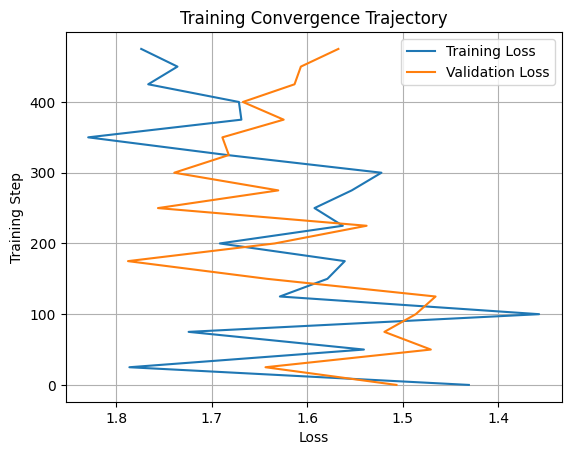

model saved


In [13]:
print(loss.item())

# Loss on X-axis, step on Y-axis
plt.plot(train_losses, train_steps, label="Training Loss")
plt.plot(val_losses, train_steps, label="Validation Loss")

plt.xlabel("Loss")
plt.ylabel("Training Step")
plt.title("Training Convergence Trajectory")

plt.gca().invert_xaxis()  
# plt.gca().invert_yaxis()  

plt.legend()
plt.grid(True)
plt.show()

with open('model-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

In [14]:
prompt = 'Hello!'
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
print(generated_chars)

Hello! Can you see me?

He logation vedy will highed It that the butdle BriakvesCovia petose the mublit that the cotionary
